In [ ]:
!pip install requests bs4 pandas

In [1]:
import requests
from bs4 import BeautifulSoup

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36 Edg/108.0.1462.42"
}  # 将程序发出的请求伪装成浏览器
text = requests.get("https://piaofang.maoyan.com/rankings/year", headers=headers).text
# 通过requests请求到电影票房的网页
main_page = BeautifulSoup(text, "html.parser")  # 后面这个是html的解析器
# 使用BeautifulSoup对text进行解析
div = main_page.find("div", attrs={"id": "ranks-list"})
# 找到名为div且id为ranks-list的所有标签
with open("MovieData.csv", mode="w", encoding="utf-8", newline='') as f:  # 创建一个名为MovieData.csv的文件，放在变量f中，且可以在其后面直接追加文字
    f.write("片名,上映日期,票房(万元),平均票价,场均人次\n")  # 写入表头
    uls = div.find_all('ul')
    # 找到div元素中所有名为ul的元素，并存储在uls变量中
    for ul in uls:  # 对uls中的元素进行遍历
        lst1 = ul.find_all("li", attrs={"class": "col1"})  # 找到ul中所有类名为col1的Li元素，并储存在lst1
        lst2 = ul.find_all("li", attrs={"class": "col2"})  # 找到ul中所有类名为col2的Li元素，并储存在lst2
        lst3 = ul.find_all("li", attrs={"class": "col3"})  # 找到ul中所有类名为col3的Li元素，并储存在lst3
        lst4 = ul.find_all("li", attrs={"class": "col4"})  # 找到ul中所有类名为col4的Li元素，并储存在lst4
        row_data = []  # 用于存储当前行的数据
        for li in lst1:  # 对lst1中的元素进行遍历
            ps = li.find_all("p")  # 找到ps中所有p元素，并储存在ps
            for p in ps:  # 对ps中的元素进行遍历
                row_data.append(p.text.strip())  # 将p标签中的文本去除分隔符后添加到row_data中
        for li in lst2:  # 对lst2中的元素进行遍历
            row_data.append(li.text.strip())  # 将li标签中的文本去除分隔符后添加到row_data中
        for li in lst3:  # 对lst3中的元素进行遍历
            row_data.append(li.text.strip())  # 将li标签中的文本去除分隔符后添加到row_data中
        for li in lst4:  # 对lst4中的元素进行遍历
            row_data.append(li.text.strip())  # 将li标签中的文本去除分隔符后添加到row_data中
        f.write(",".join(row_data) + "\n")  # 使用join方法将row_data中的元素连接成一个字符串，并写入文件

In [2]:
# 筛选掉MovieData.csv中，上映日期在2021年之前的数据

import pandas as pd

# 读取CSV文件
df = pd.read_csv('MovieData.csv')

# 将'上映日期'列转换为日期格式
df['上映日期'] = pd.to_datetime(df['上映日期'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0])

# 筛选出2021年及之后上映的电影
filtered_df = df[df['上映日期'] >= '2021-01-01']

# 将数据条目按照上映日期先后排序
sorted_df = filtered_df.sort_values('上映日期')

# 输出到MovieAfter2021.csv
sorted_df.to_csv('MovieAfter2021.csv', index=False)
print(sorted_df)


           片名       上映日期  票房(万元)       平均票价  场均人次
2      你好，李焕英 2021-02-12  541320  44.756565    24
6      唐人街探案3 2021-02-12  452356  47.602540    29
241  熊出没·狂野大陆 2021-02-12   59531  43.313114    18
164      人潮汹涌 2021-02-12   76237  41.317425    10
113     刺杀小说家 2021-02-12  103520  47.265385    16
..        ...        ...     ...        ...   ...
17        抓娃娃 2024-07-16  332752  41.382668    14
159    异形：夺命舰 2024-08-16   78636  40.556637     7
89   志愿军：存亡之战 2024-09-30  120550  41.347370    10
199   毒液：最后一舞 2024-10-23   68310  41.331560     6
214       好东西 2024-11-22   64896  42.159836     6

[84 rows x 5 columns]


In [3]:
import requests
import re
import importlib
import sys
import pandas as pd
import datetime

importlib.reload(sys)


class Spider(object):
    def __init__(self):
        print(u'开始爬取...')

    # 获取网页源码，返回页面所有信息
    def get_source(self, url):
        html = requests.get(url)
        return html.text

    # 改变url实现抓取所有年份的假日，得所有url列表
    def change_page(self, url, now_page, total_page):
        page_group = []
        for i in range(now_page, total_page + 1):
            link = url[:26] + str(i) + url[30:]
            page_group.append(link)
        return page_group

    # 把页面上假日的table截取出来，返回字符串
    def get_every_table(self, source):
        everytable = re.findall('(<table style=.*?</table>)', source, re.S)
        return everytable

    # 取出放假日期范围，返回日期列表
    def get_holiday(self, year, string):
        string = "".join(re.findall('\d.*', string, re.S))
        if string.find('年') >= 0:
            string = string[5:]
        if string.find('~') == -1:
            string = string + '~' + string
        str1 = string.split('~')
        m1 = "".join(re.findall('\d.*(?=月\d)', str1[0], re.S))
        d1 = "".join(re.findall('(?<=月).*\d', str1[0], re.S))
        m2 = "".join(re.findall('\d.*(?=月\d)', str1[1], re.S))
        d2 = "".join(re.findall('(?<=月).*\d', str1[1], re.S))

        # 规范化日期格式为yyyy mm dd
        if int(m1) < 10:
            m1 = '0' + m1
        if int(d1) < 10:
            d1 = '0' + d1
        if int(m2) < 10:
            m2 = '0' + m2
        if int(d2) < 10:
            d2 = '0' + d2

        if int(m1) == 12:
            y1 = str(int(year) - 1)  # 如果元旦前是12月则月份要取少一年
        else:
            y1 = year

        # 根据日期范围获取所有连续日期
        date_list = []
        begin_date = datetime.datetime.strptime(y1 + m1 + d1, "%Y%m%d")
        end_date = datetime.datetime.strptime(year + m2 + d2, "%Y%m%d")
        while begin_date <= end_date:
            date_str = begin_date.strftime("%Y%m%d")
            date_list.append(date_str)
            begin_date += datetime.timedelta(days=1)

        return date_list

    # 取出调休上班日期，返回日期列表
    def get_workday(self, year, string):
        string = "".join(re.findall('\d.*', string, re.S))
        if string.find('年') >= 0:
            string = string[5:]
        list1 = re.split('[，、]', string)
        list2 = []
        for a in list1:
            m1 = "".join(re.findall('\d.*(?=月\d)', a, re.S))
            d1 = "".join(re.findall('(?<=月).*\d', a, re.S))
            if int(m1) == 12:
                y1 = str(int(year) - 1)
            else:
                y1 = year
            if int(m1) < 10:
                m1 = '0' + m1
            if int(d1) < 10:
                d1 = '0' + d1

            list2.append(y1 + m1 + d1)

        return list2

    # 分割源码获得每年所有假日表：日期、节日名称、是否放假
    def get_info(self, eachyear):
        info = {}
        ho = re.findall('jiad/">(.*?)</a>', eachyear, re.S)  # 节日名称列表
        year = re.search('<a href="/(.*?)_', eachyear, re.S).group(1)  # 年份字符串
        a = re.findall('<td>(.*?)</td>', eachyear, re.S)  # 除了节日名称列的其他数据列表，包括放假时间、调休上班日期、放假天数
        j = len(a)

        # 得出放假日期
        i = 0
        k = 0
        df = pd.DataFrame()
        while i < j:
            if i > j:
                continue
            holidayname = ''.join(ho[k])
            holiday_list = list(map(int, self.get_holiday(year, a[i])))
            df1 = pd.DataFrame(holiday_list, columns=['period_id'])
            df1['holiday_name'], df1['is_holiday'] = [holidayname, 1]
            df = pd.concat([df, df1])
            i += 3
            k += 1

        # 得出调休上班日期
        m = 1
        n = 0
        df2 = pd.DataFrame()
        while m < j:
            if m > j:
                continue
            holidayname = ''.join(ho[n])
            data = a[m]
            checkdata = a[m].find('休')  # 是否包含休
            checkdata2 = a[m].find('无')  # 是否包含无
            m += 3
            n += 1
            if checkdata >= 0 or checkdata2 >= 0:  # 如果该节日没有特殊调休安排则跳过循环
                continue
            work_list = list(map(int, self.get_workday(year, data)))
            df_temp = pd.DataFrame(work_list, columns=['period_id'])
            df_temp['holiday_name'], df_temp['is_holiday'] = [holidayname, 0]
            df2 = pd.concat([df2, df_temp])
        return pd.concat([df, df2])

    # 将结果写入csv
    def write2csv(self, filepath, data):
        data.to_csv(filepath, index=False)

    # 将结果追加到csv
    def add2csv(self, filepath, data):
        data.to_csv(filepath, mode='a', index=False, header=False)


if __name__ == '__main__':
    # 初始化参数
    url = 'https://fangjia.51240.com/2024__fangjia/'  # 抓取的页面
    start_page = 2021  # 抓取开始年份
    end_page = 2024  # 抓取结束年份
    filepath = 'holiday.csv'  # 写入csv文件路径

    print(u'初始化类..')
    myspider = Spider()
    all_links = myspider.change_page(url, start_page, end_page)
    df = pd.DataFrame()
    for link in all_links:
        print(u'正在处理页面..' + link)
        html = myspider.get_source(link)
        everyyear = myspider.get_every_table(html)
        for each in everyyear:
            df = pd.concat([df, myspider.get_info(each)])
    df.index = range(len(df))
    df.sort_values(by='period_id', inplace=True)

    # 生成csv
    myspider.write2csv(filepath, df)

    # csv中增加内容
    # myspider.add2csv(filepath, df)  # 写入csv，并追加内容

    print('写入CSV完成！')


初始化类..
开始爬取...
正在处理页面..https://fangjia.51240.com/2021__fangjia/


<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:41: SyntaxWarning: invalid escape sequence '\d'
<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\d'
<>:74: SyntaxWarning: invalid escape sequence '\d'
<>:80: SyntaxWarning: invalid escape sequence '\d'
<>:81: SyntaxWarning: invalid escape sequence '\d'
<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:41: SyntaxWarning: invalid escape sequence '\d'
<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\d'
<>:74: SyntaxWarning: invalid escape sequence '\d'
<>:80: SyntaxWarning: invalid escape sequence '\d'
<>:81: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Steve\AppData\Local\Temp\ipykernel_14308\2531185316.py:35: SyntaxWarning: invalid escape sequence '\d'
  string = "".join(re.findall('\d.*', string, re.S))
C:\Users\Steve\AppD

正在处理页面..https://fangjia.51240.com/2022__fangjia/
正在处理页面..https://fangjia.51240.com/2023__fangjia/
正在处理页面..https://fangjia.51240.com/2024__fangjia/
写入CSV完成！


findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
C:\Users\Steve\miniconda3\Lib\site-packages\IPython\core\pylabto

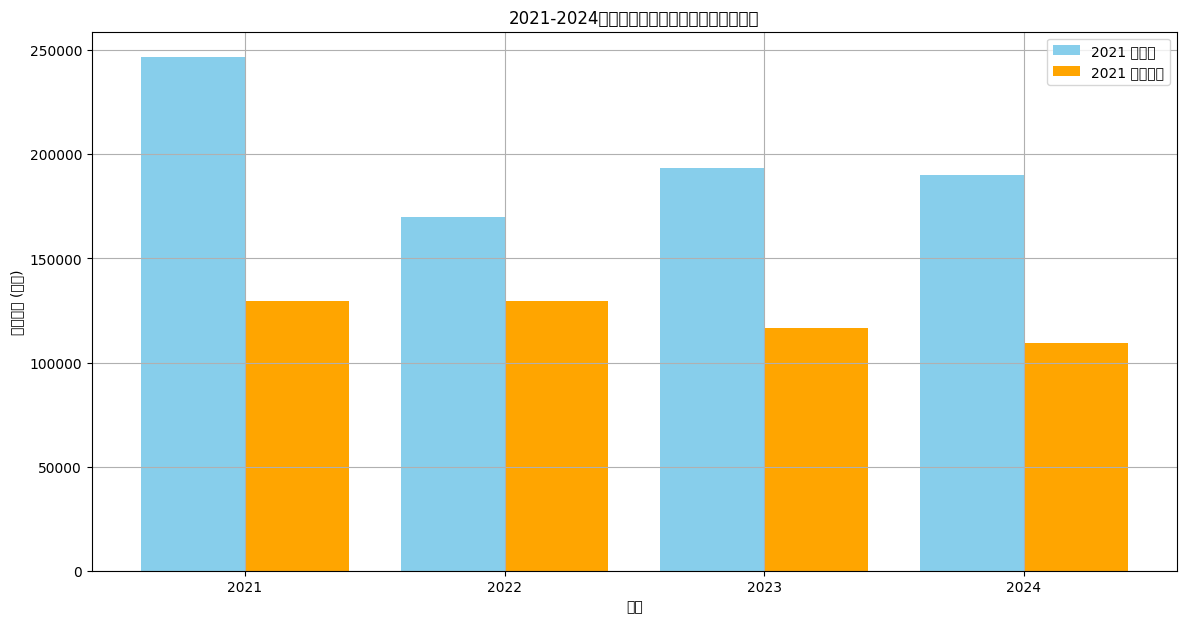

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime

# 设置中文字体
rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei'] 
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 1. 数据加载
movie_df = pd.read_csv('MovieAfter2021.csv')
holiday_df = pd.read_csv('holiday.csv')

# 2. 数据预处理
# 将上映日期转换为datetime格式
movie_df['上映日期'] = pd.to_datetime(movie_df['上映日期'])

# 将period_id转换为datetime格式
holiday_df['period_id'] = pd.to_datetime(holiday_df['period_id'], format='%Y%m%d')

# 3. 数据分析
# 创建一个列来标记电影上映日期是否为法定节假日
movie_df['is_holiday'] = movie_df['上映日期'].apply(lambda x: 1 if x in holiday_df[holiday_df['is_holiday'] == 1]['period_id'].values else 0)

# 按年份和是否为法定节假日分组，计算平均票房
grouped = movie_df.groupby([movie_df['上映日期'].dt.year, 'is_holiday'])['票房(万元)'].mean().reset_index()

# 4. 数据可视化
# 设置图形大小
plt.figure(figsize=(14, 7))

# 绘制每年节假日和非节假日的平均票房
for year in grouped['上映日期'].unique():
    holiday_data = grouped[(grouped['上映日期'] == year) & (grouped['is_holiday'] == 1)]
    non_holiday_data = grouped[(grouped['上映日期'] == year) & (grouped['is_holiday'] == 0)]
    
    plt.bar(year - 0.2, holiday_data['票房(万元)'].values[0], width=0.4, label=f'{year} 节假日' if year == 2021 else '', color='skyblue')
    plt.bar(year + 0.2, non_holiday_data['票房(万元)'].values[0], width=0.4, label=f'{year} 非节假日' if year == 2021 else '', color='orange')

# 添加标题和标签
plt.title('2021-2024年每年节假日和非节假日的平均票房')
plt.xlabel('年份')
plt.ylabel('平均票房 (万元)')
plt.xticks(range(2021, 2025))
plt.legend()
plt.grid(True)
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
C:\Users\Steve\AppData\Local\Temp\ipykernel_14308\1189896271.py:68: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Steve\AppData\Local\Temp\ipykernel_14308\1189896271.py:68: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Steve\AppData\Local\Temp\ipykernel_14308\1189896271.py:68: UserWarning: Glyph 27573 (\N{CJK UNIFIED IDEOGRAPH-6BB5}) missing from font(s) DejaVu Sans.
  plt.tigh

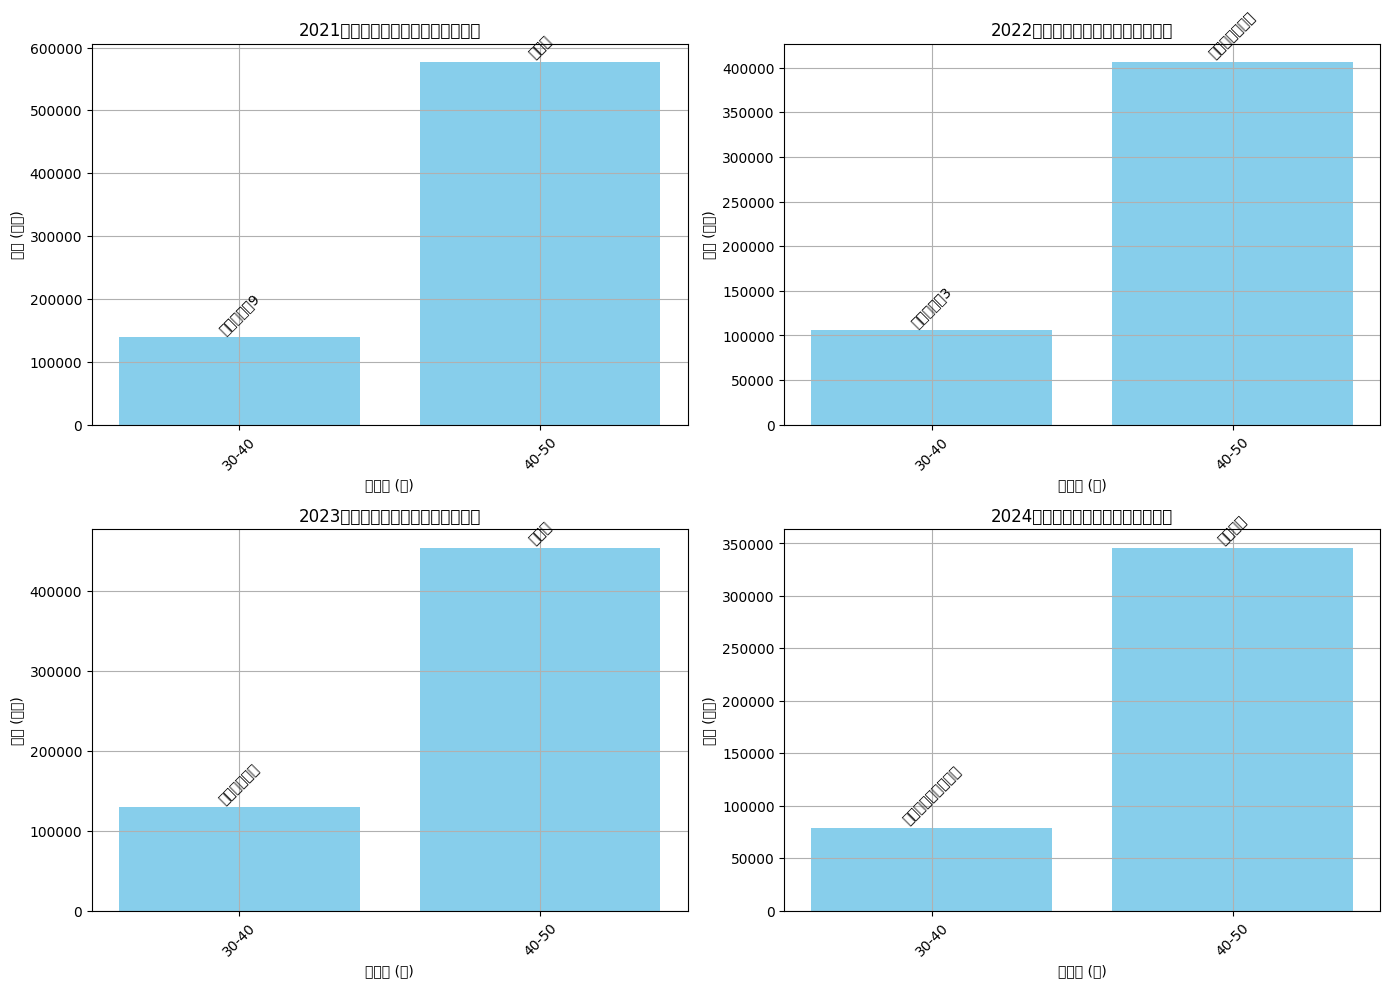

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 1. 数据加载
movie_df = pd.read_csv('MovieAfter2021.csv')

# 设置中文字体
rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 使用文泉驿正黑
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# 2. 数据预处理
# 将上映日期转换为datetime格式
movie_df['上映日期'] = pd.to_datetime(movie_df['上映日期'])

# 提取年份
movie_df['年份'] = movie_df['上映日期'].dt.year

# 3. 票价分段
# 定义票价分段区间
price_bins = range(0, 60, 10)  # 0-10, 10-20, ..., 50-60
price_labels = [f'{i}-{i+10}' for i in price_bins[:-1]]

# 将平均票价分段
movie_df['票价段'] = pd.cut(movie_df['平均票价'], bins=price_bins, labels=price_labels, right=False)

# 4. 数据分析
# 创建一个字典来存储每年每个票价段内票房最高的电影
top_movies_by_year_and_price_range = {}

for year in range(2021, 2025):
    top_movies_by_year_and_price_range[year] = {}
    yearly_data = movie_df[movie_df['年份'] == year]
    
    for price_range in price_labels:
        range_data = yearly_data[yearly_data['票价段'] == price_range]
        if not range_data.empty:
            top_movie = range_data.loc[range_data['票房(万元)'].idxmax()]
            top_movies_by_year_and_price_range[year][price_range] = {
                '片名': top_movie['片名'],
                '票房(万元)': top_movie['票房(万元)'],
                '平均票价': top_movie['平均票价']
            }

# 5. 数据可视化
# 设置图形大小
plt.figure(figsize=(14, 10))

# 绘制每年不同票价段最受欢迎的电影票房
for year in range(2021, 2025):
    data = top_movies_by_year_and_price_range[year]
    prices = list(data.keys())
    box_offices = [data[price]['票房(万元)'] for price in prices]
    
    plt.subplot(2, 2, year - 2020)
    plt.bar(prices, box_offices, color='skyblue')
    plt.title(f'{year}年不同票价段最受欢迎电影票房')
    plt.xlabel('票价段 (元)')
    plt.ylabel('票房 (万元)')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # 添加每个票价段最受欢迎电影的名称
    for i, price in enumerate(prices):
        plt.text(i, box_offices[i] + 1000, data[price]['片名'], ha='center', va='bottom', rotation=45)

plt.tight_layout()
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of 

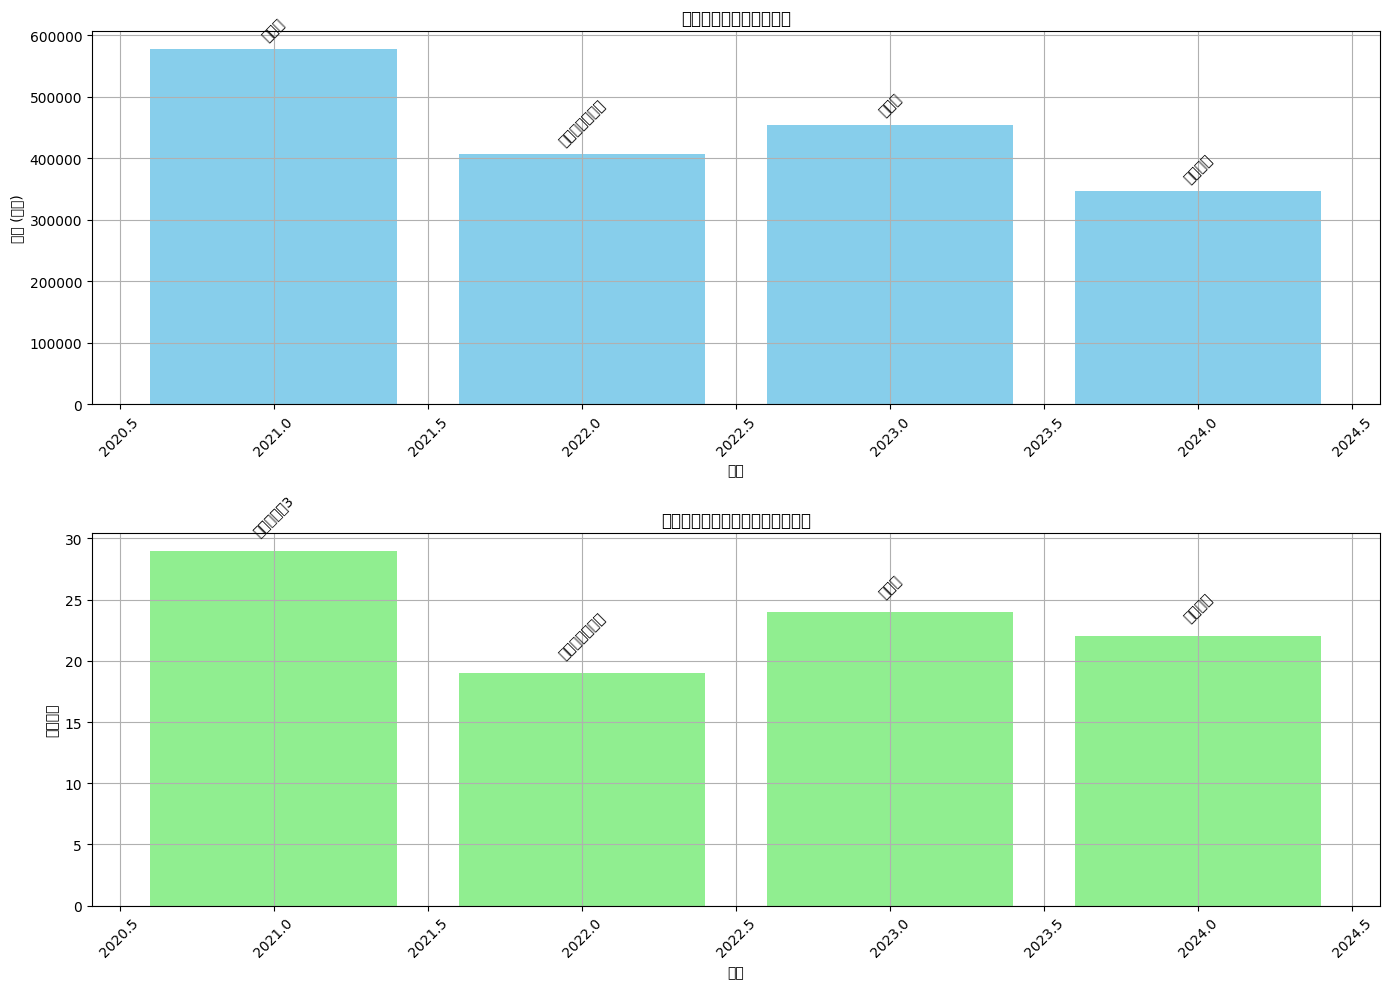

Year: 2021
票房最高的电影: 长津湖 (票房: 577534 万元)
场均人次最多的电影: 唐人街探案3 (场均人次: 29)
--------------------------------------------------
Year: 2022
票房最高的电影: 长津湖之水门桥 (票房: 406745 万元)
场均人次最多的电影: 长津湖之水门桥 (场均人次: 19)
--------------------------------------------------
Year: 2023
票房最高的电影: 满江红 (票房: 454435 万元)
场均人次最多的电影: 满江红 (场均人次: 24)
--------------------------------------------------
Year: 2024
票房最高的电影: 热辣滚烫 (票房: 346055 万元)
场均人次最多的电影: 热辣滚烫 (场均人次: 22)
--------------------------------------------------


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 设置中文字体
rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 使用文泉驿正黑
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# 1. 数据加载
movie_df = pd.read_csv('MovieAfter2021.csv')

# 2. 数据预处理
# 将上映日期转换为datetime格式
movie_df['上映日期'] = pd.to_datetime(movie_df['上映日期'])

# 提取年份
movie_df['年份'] = movie_df['上映日期'].dt.year

# 3. 数据分析
# 创建字典来存储每年票房最高的电影和场均人次最多的电影
top_movies_by_year = {}

for year in range(2021, 2025):
    yearly_data = movie_df[movie_df['年份'] == year]

    # 找到票房最高的电影
    highest_box_office_movie = yearly_data.loc[yearly_data['票房(万元)'].idxmax()]
    highest_avg_audience_movie = yearly_data.loc[yearly_data['场均人次'].idxmax()]

    top_movies_by_year[year] = {
        '票房最高': {
            '片名': highest_box_office_movie['片名'],
            '票房(万元)': highest_box_office_movie['票房(万元)'],
            '平均票价': highest_box_office_movie['平均票价'],
            '场均人次': highest_box_office_movie['场均人次']
        },
        '场均人次最高': {
            '片名': highest_avg_audience_movie['片名'],
            '票房(万元)': highest_avg_audience_movie['票房(万元)'],
            '平均票价': highest_avg_audience_movie['平均票价'],
            '场均人次': highest_avg_audience_movie['场均人次']
        }
    }

# 4. 数据可视化
# 设置图形大小
plt.figure(figsize=(14, 10))

# 绘制每年票房最高的电影票房和场均人次
years = list(top_movies_by_year.keys())
box_office_movies = [top_movies_by_year[year]['票房最高']['片名'] for year in years]
box_office_values = [top_movies_by_year[year]['票房最高']['票房(万元)'] for year in years]

avg_audience_movies = [top_movies_by_year[year]['场均人次最高']['片名'] for year in years]
avg_audience_values = [top_movies_by_year[year]['场均人次最高']['场均人次'] for year in years]

# 票房最高的电影
plt.subplot(2, 1, 1)
plt.bar(years, box_office_values, color='skyblue')
plt.title('每年票房最高的电影票房')
plt.xlabel('年份')
plt.ylabel('票房 (万元)')
plt.xticks(rotation=45)
plt.grid(True)

# 在每个柱状图上标注电影名称
for i, year in enumerate(years):
    plt.text(year, box_office_values[i] + 10000, box_office_movies[i], ha='center', va='bottom', rotation=45)

# 场均人次最高的电影
plt.subplot(2, 1, 2)
plt.bar(years, avg_audience_values, color='lightgreen')
plt.title('每年场均人次最多的电影场均人次')
plt.xlabel('年份')
plt.ylabel('场均人次')
plt.xticks(rotation=45)
plt.grid(True)

# 在每个柱状图上标注电影名称
for i, year in enumerate(years):
    plt.text(year, avg_audience_values[i] + 1, avg_audience_movies[i], ha='center', va='bottom', rotation=45)

plt.tight_layout()
plt.show()

# 打印结果
for year in years:
    print(f"Year: {year}")
    print(f"票房最高的电影: {top_movies_by_year[year]['票房最高']['片名']} (票房: {top_movies_by_year[year]['票房最高']['票房(万元)']} 万元)")
    print(f"场均人次最多的电影: {top_movies_by_year[year]['场均人次最高']['片名']} (场均人次: {top_movies_by_year[year]['场均人次最高']['场均人次']})")
    print("-" * 50)